# 8章：ニューラルネット
第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ。  

## 70. 単語ベクトルの和による特徴量

問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例$x_i$の特徴ベクトル$\boldsymbol{x}_i$を並べた行列$X$と正解ラベルを並べた行列（ベクトル）$Y$を作成したい．

$$
X = \begin{pmatrix} 
  \boldsymbol{x}_1 \\ 
  \boldsymbol{x}_2 \\ 
  \dots \\ 
  \boldsymbol{x}_n \\ 
\end{pmatrix} \in \mathbb{R}^{n \times d},
Y = \begin{pmatrix} 
  y_1 \\ 
  y_2 \\ 
  \dots \\ 
  y_n \\ 
\end{pmatrix} \in \mathbb{N}^{n}
$$


 ここで，$n$は学習データの事例数であり，$\boldsymbol x_i \in \mathbb{R}^d$と$y_i \in \mathbb N$はそれぞれ，$i \in \{1, \dots, n\}$番目の事例の特徴量ベクトルと正解ラベルを表す．
 なお，今回は「ビジネス」「科学技術」「エンターテイメント」「健康」の4カテゴリ分類である．$\mathbb N_{<4}$で$4$未満の自然数（$0$を含む）を表すことにすれば，任意の事例の正解ラベル$y_i$は$y_i \in \mathbb N_{<4}$で表現できる．
 以降では，ラベルの種類数を$L$で表す（今回の分類タスクでは$L=4$である）．

 $i$番目の事例の特徴ベクトル$\boldsymbol x_i$は，次式で求める．

 $$\boldsymbol x_i = \frac{1}{T_i} \sum_{t=1}^{T_i} \mathrm{emb}(w_{i,t})$$

 ここで，$i$番目の事例は$T_i$個の（記事見出しの）単語列$(w_{i,1}, w_{i,2}, \dots, w_{i,T_i})$から構成され，$\mathrm{emb}(w) \in \mathbb{R}^d$は単語$w$に対応する単語ベクトル（次元数は$d$）である．  
 すなわち，$i$番目の事例の記事見出しを，その見出しに含まれる単語のベクトルの平均で表現したものが$\boldsymbol x_i$である．今回は単語ベクトルとして，問題60でダウンロードしたものを用いればよい．$300$次元の単語ベクトルを用いたので，$d=300$である．  
 $i$番目の事例のラベル$y_i$は，次のように定義する．

$$
y_i = \begin{cases}
0 & (\mbox{記事}\boldsymbol x_i\mbox{が「ビジネス」カテゴリの場合}) \\
1 & (\mbox{記事}\boldsymbol x_i\mbox{が「科学技術」カテゴリの場合}) \\
2 & (\mbox{記事}\boldsymbol x_i\mbox{が「エンターテイメント」カテゴリの場合}) \\
3 & (\mbox{記事}\boldsymbol x_i\mbox{が「健康」カテゴリの場合}) \\
\end{cases}
$$

なお，カテゴリ名とラベルの番号が一対一で対応付いていれば，上式の通りの対応付けでなくてもよい．

以上の仕様に基づき，以下の行列・ベクトルを作成し，ファイルに保存せよ．

 + 学習データの特徴量行列: $X_{\rm train} \in \mathbb{R}^{N_t \times d}$
 + 学習データのラベルベクトル: $Y_{\rm train} \in \mathbb{N}^{N_t}$
 + 検証データの特徴量行列: $X_{\rm valid} \in \mathbb{R}^{N_v \times d}$
 + 検証データのラベルベクトル: $Y_{\rm valid} \in \mathbb{N}^{N_v}$
 + 評価データの特徴量行列: $X_{\rm test} \in \mathbb{R}^{N_e \times d}$
 + 評価データのラベルベクトル: $Y_{\rm test} \in \mathbb{N}^{N_e}$

なお，$N_t, N_v, N_e$はそれぞれ，学習データの事例数，検証データの事例数，評価データの事例数である．

In [1]:
!conda info


     active environment : None
       user config file : /Users/makino/.condarc
 populated config files : 
          conda version : 4.13.0
    conda-build version : 3.21.9
         python version : 3.8.8.final.0
       virtual packages : __osx=10.16=0
                          __unix=0=0
                          __archspec=1=x86_64
       base environment : /Users/makino/.pyenv/versions/anaconda3-2021.05  (writable)
      conda av data dir : /Users/makino/.pyenv/versions/anaconda3-2021.05/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/osx-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/osx-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /Users/makino/.pyenv/versions/anaconda3-2021.05/pkgs
                          /Users/makino/.conda/pkgs
       envs directories : /Users/makino/.pyenv/versions/anaco

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors
import sys

In [3]:
#データの取り出し
train = pd.read_table('data/train.txt')
valid = pd.read_table('data/valid.txt')
test = pd.read_table('data/test.txt')

In [4]:
#タイトル列のみの抽出→特徴量の生成
X_train = train['TITLE']
X_valid = valid['TITLE']
X_test = test['TITLE']

In [5]:
#カテゴリ列のみの抽出→ラベルの生成
Y_train = train['CATEGORY']
Y_valid = valid['CATEGORY']
Y_test = test['CATEGORY']

In [6]:
#word2vecをダウンロード
EMBEDDING_FILE = 'data/GoogleNews-vectors-negative300.bin.gz'
word_vectors = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [7]:
#ベクトル表現の生成関数を定義
def create_vector(data):
    result = []
    for i in range(len(data)):
        listdata = data[i].split(' ')
        subresult = np.zeros(300)
        number = 0
        for j in range(len(listdata)):
            try:
                subresult += word_vectors[listdata[j]]
                number += 1
            except Exception as e: #単語埋め込み範囲外の語彙を見つけた時に例外処理
                pass
        if number == 0:
            result.append(subresult)
        else:
            result.append(subresult/number)
    return result

In [8]:
#特徴量においてベクトル表現を生成
X_train = create_vector(X_train)
X_valid = create_vector(X_valid)
X_test = create_vector(X_test)

In [9]:
#ラベルにおいて特徴量を生成
dct_int = {'b': 0, 't': 1, 'e': 2,'m': 3}
Y_train = Y_train.replace(dct_int)
Y_valid = Y_valid.replace(dct_int)
Y_test = Y_test.replace(dct_int)

In [10]:
#型を合わせる
X_train = torch.tensor(np.array(X_train)).float()
X_valid = torch.tensor(np.array(X_valid)).float()
X_test = torch.tensor(np.array(X_test)).float()

Y_train = torch.tensor(Y_train.values)
Y_valid = torch.tensor(Y_valid.values)
Y_test = torch.tensor(Y_test.values)

In [11]:
torch.save(X_train, 'data/X_train.pt')
torch.save(X_valid, 'data/X_valid.pt')
torch.save(X_test, 'data/X_test.pt')

torch.save(Y_train, 'data/Y_train.pt')
torch.save(Y_valid, 'data/Y_valid.pt')
torch.save(Y_test, 'data/Y_test.pt')

In [12]:
sys.getsizeof(X_train)

72

In [13]:
sys.getsizeof(Y_train)

72

In [14]:
print(X_train[0])

tensor([ 0.0592,  0.0824, -0.0097,  0.0270,  0.0154,  0.0245,  0.0567, -0.1834,
         0.0445,  0.1768, -0.0316, -0.0606, -0.0335, -0.0288, -0.1393,  0.0919,
         0.0998,  0.1269,  0.0377, -0.0957,  0.0409,  0.0197,  0.0662, -0.0424,
         0.1469,  0.0632, -0.0727,  0.0196,  0.0128,  0.0708, -0.0298, -0.0847,
         0.0216,  0.0292, -0.0354,  0.0513, -0.0003,  0.0316,  0.0469,  0.0959,
         0.0652, -0.0178,  0.0903,  0.0345, -0.0337, -0.0521, -0.0040,  0.0009,
        -0.0024,  0.0496, -0.0199,  0.0328,  0.0528,  0.0122, -0.0247,  0.0053,
        -0.0511, -0.0136,  0.0618, -0.0557, -0.0510,  0.0078, -0.1112, -0.0732,
        -0.0790,  0.0720, -0.0147,  0.0128,  0.0134,  0.0908,  0.1413, -0.0166,
         0.0152, -0.0697, -0.1124, -0.0726,  0.0217,  0.0623,  0.0425, -0.0262,
        -0.0206, -0.0588,  0.0466,  0.0362,  0.0951, -0.0777, -0.1627,  0.0812,
        -0.0048,  0.0666,  0.0220,  0.0350, -0.0831, -0.0594,  0.0467, -0.0891,
         0.0581, -0.0577,  0.1133, -0.00

In [15]:
print(len(X_train[0]))

300


## 71. 単層ニューラルネットワークによる予測
問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．

$$ 
\hat{y}_1=softmax(x_1W),\\\hat{Y}=softmax(X_{[1:4]}W)
$$


ただし，$softmax$はソフトマックス関数，$X_{[1:4]}∈\mathbb{R}^{4×d}$は特徴ベクトル$x_1$,$x_2$,$x_3$,$x_4$を縦に並べた行列である．

$$
X_{[1:4]}=\begin{pmatrix}x_1\\x_2\\x_3\\x_4\end{pmatrix}
$$

行列$W \in \mathbb{R}^{d \times L}$は単層ニューラルネットワークの重み行列で，ここではランダムな値で初期化すればよい（問題73以降で学習して求める）．  
なお，$\hat{\boldsymbol y_1} \in \mathbb{R}^L$は未学習の行列$W$で事例$x_1$を分類したときに，各カテゴリに属する確率を表すベクトルである．
同様に，$\hat{Y} \in \mathbb{R}^{n \times L}$は，学習データの事例$x_1, x_2, x_3, x_4$について，各カテゴリに属する確率を行列として表現している．


In [16]:
X_train = torch.load('data/X_train.pt')
X_valid = torch.load('data/X_valid.pt')
X_test = torch.load('data/X_test.pt')
Y_train = torch.load('data/Y_train.pt')
Y_valid = torch.load('data/Y_valid.pt')
Y_test = torch.load('data/Y_test.pt')

In [17]:
print(X_train[0])
print(Y_train[0])

tensor([ 0.0592,  0.0824, -0.0097,  0.0270,  0.0154,  0.0245,  0.0567, -0.1834,
         0.0445,  0.1768, -0.0316, -0.0606, -0.0335, -0.0288, -0.1393,  0.0919,
         0.0998,  0.1269,  0.0377, -0.0957,  0.0409,  0.0197,  0.0662, -0.0424,
         0.1469,  0.0632, -0.0727,  0.0196,  0.0128,  0.0708, -0.0298, -0.0847,
         0.0216,  0.0292, -0.0354,  0.0513, -0.0003,  0.0316,  0.0469,  0.0959,
         0.0652, -0.0178,  0.0903,  0.0345, -0.0337, -0.0521, -0.0040,  0.0009,
        -0.0024,  0.0496, -0.0199,  0.0328,  0.0528,  0.0122, -0.0247,  0.0053,
        -0.0511, -0.0136,  0.0618, -0.0557, -0.0510,  0.0078, -0.1112, -0.0732,
        -0.0790,  0.0720, -0.0147,  0.0128,  0.0134,  0.0908,  0.1413, -0.0166,
         0.0152, -0.0697, -0.1124, -0.0726,  0.0217,  0.0623,  0.0425, -0.0262,
        -0.0206, -0.0588,  0.0466,  0.0362,  0.0951, -0.0777, -0.1627,  0.0812,
        -0.0048,  0.0666,  0.0220,  0.0350, -0.0831, -0.0594,  0.0467, -0.0891,
         0.0581, -0.0577,  0.1133, -0.00

In [18]:
#ニューラルネットワーク構築
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(300, 4, bias=False)
        
    def forward(self, input):
        output = self.layer1(input)
        return output
    
model = NeuralNetwork()

In [19]:
#活性化関数の定義
activation = nn.Softmax(dim=0)

#Yの生成
result = []
for i in range(4):
    result.append(model(X_train[i]))


#Yのプリント
print(result)

'''
jupyter notebookでmodel(入力)を実行しようとすると

Kernel Restarting
The kernel for masahiro_makino_chapter08.ipynb appears to have died. It will restart automatically.

とエラーが出る。ちなみにサーバー上でPythonのスクリプトファイルを実行すればエラーが出ることなく実行できます。
'''

[tensor([-0.0388,  0.0192,  0.0382, -0.0127], grad_fn=<SqueezeBackward3>), tensor([-0.0369,  0.0025,  0.0092, -0.0384], grad_fn=<SqueezeBackward3>), tensor([-0.0232,  0.0051, -0.0154, -0.0167], grad_fn=<SqueezeBackward3>), tensor([-0.0690, -0.0330, -0.0011, -0.0573], grad_fn=<SqueezeBackward3>)]


'\njupyter notebookでmodel(入力)を実行しようとすると\n\nKernel Restarting\nThe kernel for masahiro_makino_chapter08.ipynb appears to have died. It will restart automatically.\n\nとエラーが出る。ちなみにサーバー上でPythonのスクリプトファイルを実行すればエラーが出ることなく実行できます。\n'

## 72. 損失と勾配の計算

学習データの事例x1
と事例集合x1,x2,x3,x4
に対して，クロスエントロピー損失と，行列W
に対する勾配を計算せよ．なお，ある事例xi
に対して損失は次式で計算される．

$$
l_i=−log[事例x_iがy_iに分類される確率]
$$

ただし，事例集合に対するクロスエントロピー損失は，その集合に含まれる各事例の損失の平均とする．

In [20]:
loss = nn.CrossEntropyLoss()
loss = loss(model(X_train[0]), Y_train[0])#long型にする必要あり
model.zero_grad()
loss.backward()
print('x1の計算結果')
print(f'損失：{loss}')
print(f'勾配：{model.layer1.weight.grad}')

x1の計算結果
損失：1.4270175695419312
勾配：tensor([[-0.0450, -0.0626,  0.0074,  ...,  0.0151,  0.0036,  0.0360],
        [ 0.0150,  0.0209, -0.0025,  ..., -0.0051, -0.0012, -0.0120],
        [ 0.0153,  0.0213, -0.0025,  ..., -0.0052, -0.0012, -0.0123],
        [ 0.0146,  0.0203, -0.0024,  ..., -0.0049, -0.0012, -0.0117]])


In [21]:
print('\n損失が正しく計算されているか確認')
loss1 = nn.CrossEntropyLoss()
print((loss1(model(X_train[0]), Y_train[0])+ loss1(model(X_train[1]), Y_train[1]) + loss1(model(X_train[2]), Y_train[2]) + loss1(model(X_train[3]), Y_train[3]))/4)


損失が正しく計算されているか確認
tensor(1.4098, grad_fn=<DivBackward0>)


***
### torch.nn.CrossEntropyLoss()
損失関数内でsoftmax関数を適用する式になっているためニューラルネットワーク内で最後にsoftmax関数を適用する必要がない
[公式レファレンス](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

ニューラルネットワーク内でもsoftmax関数を適用していると損失関数内で再びsoftmax関数が適用されることで２重でsoftmax関数をかけることになり、想定している出力が得られない
***

## 73. 確率的勾配降下法による学習

確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列W
を学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [22]:
#損失関数の定義
loss_entropy = nn.CrossEntropyLoss()

#最適化手法の決定
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

EPOCHS = 2000  # 上と同じことを2000回繰り返す
for epoch in range(EPOCHS):
    optimizer.zero_grad()  # 重みとバイアスの更新で内部的に使用するデータをリセット
    outputs = model(X_train)  # 手順1：ニューラルネットワークにデータを入力
    loss = loss_entropy(outputs, Y_train)  # 手順2：正解ラベルとの比較
    loss.backward()  # 手順3-1：誤差逆伝播
    optimizer.step()  # 手順3-2：重みとバイアスの更新
    
    '''if epoch%100==99:
        print(f'損失：{loss}')
        print(f'重み：{model.layer1.weight}')'''

#活性化関数の定義
activation = nn.Softmax(dim=0)

## 74. 正解率の計測

問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [23]:
#訓練データでの正解率計算
number = 0
for i in range(len(X_train)):
    if torch.argmax(activation(model(X_train[i]))) == Y_train[i]:
        number += 1
print(f'訓練データにおける正解率：{number/len(X_train)}')

訓練データにおける正解率：0.8289917541229386


In [24]:
#評価データでの正解率計算
number = 0
for i in range(len(X_test)):
    if torch.argmax(activation(model(X_test[i]))) == Y_test[i]:
        number += 1
print(f'評価データにおける正解率：{number/len(X_test)}')

評価データにおける正解率：0.8253373313343328


In [25]:
#めんどくさいので関数定義
def accuracy(x, y):
    number = 0
    for i in range(len(x)):
        if torch.argmax(activation(model(x[i]))) == y[i]:
            number += 1
    return number/len(x)

## 75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [26]:
import matplotlib.pyplot as plt

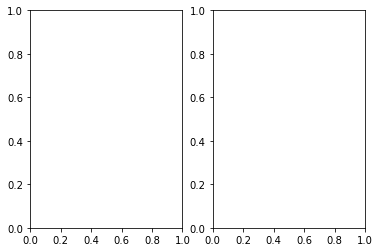

In [27]:
#グラフの設定
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

*** 
### add_subplot
1つの描画キャンパスに複数のグラフを表示させることが可能


>１つ目の引数：何行に分割するか<br>
>２つ目の引数：何列に分割するか<br>
>３つ目の引数：グラフを書く際の領域を指定

***

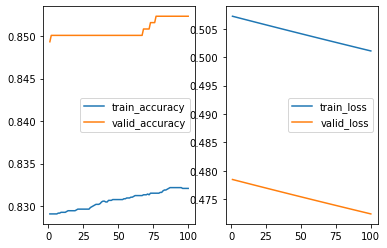

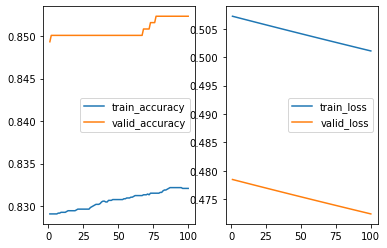

In [28]:
EPOCHS = 100  # 100回繰り返す
epoch_train_list, loss_train_list, accuracy_train_list = [], [], []
epoch_valid_list, loss_valid_list, accuracy_valid_list = [], [], []

for epoch in range(EPOCHS):
    optimizer.zero_grad()  # 重みとバイアスの更新で内部的に使用するデータをリセット
    outputs = model(X_train)  # 手順1：ニューラルネットワークにデータを入力
    loss = loss_entropy(outputs, Y_train)  # 手順2：正解ラベルとの比較
    loss.backward()  # 手順3-1：誤差逆伝播
    optimizer.step()  # 手順3-2：重みとバイアスの更新

    #訓練データでの正解率と損失の計算
    number = 0
    for i in range(len(X_train)):
        if torch.argmax(activation(model(X_train[i]))) == Y_train[i]:
            number += 1
        
    #エポック、損失、正解率をリストに格納
    epoch_train_list.append(epoch+1)
    loss_train_list.append(loss.detach().numpy())
    accuracy_train_list.append(number/len(X_train))

    #評価データでの正解率と損失の計算
    number = 0
    for i in range(len(X_valid)):
        if torch.argmax(activation(model(X_valid[i]))) == Y_valid[i]:
            number += 1 

    outputs = model(X_valid)  # 手順1：ニューラルネットワークにデータを入力
    loss = loss_entropy(outputs, Y_valid) 
    
    #エポック、損失、正解率をリストに格納
    epoch_valid_list.append(epoch+1)
    loss_valid_list.append(loss.detach().numpy())
    accuracy_valid_list.append(number/len(X_valid))
    
#グラフの設定
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

#プロット
ax1.plot(epoch_train_list, accuracy_train_list, label='train_accuracy')
ax2.plot(epoch_train_list, loss_train_list, label='train_loss')
ax1.plot(epoch_valid_list, accuracy_valid_list, label='valid_accuracy')
ax2.plot(epoch_valid_list, loss_valid_list, label='valid_loss')

#表示
ax1.legend()
ax2.legend()
fig

## 76. チェックポイント

問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．



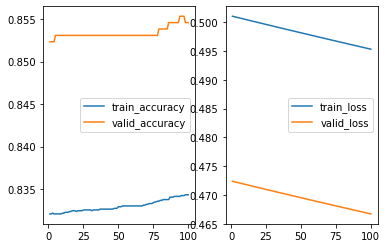

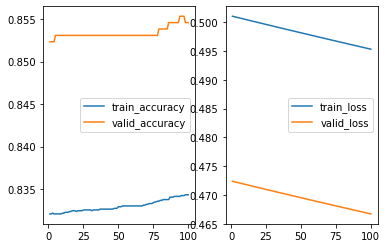

In [29]:
EPOCHS = 100  # 100回繰り返す
epoch_train_list, loss_train_list, accuracy_train_list = [], [], []
epoch_valid_list, loss_valid_list, accuracy_valid_list = [], [], []

for epoch in range(EPOCHS):
    optimizer.zero_grad()  # 重みとバイアスの更新で内部的に使用するデータをリセット
    outputs = model(X_train)  # 手順1：ニューラルネットワークにデータを入力
    loss = loss_entropy(outputs, Y_train)  # 手順2：正解ラベルとの比較
    loss.backward()  # 手順3-1：誤差逆伝播
    optimizer.step()  # 手順3-2：重みとバイアスの更新
        
    #エポック、損失、正解率をリストに格納
    epoch_train_list.append(epoch+1)
    loss_train_list.append(loss.detach().numpy())
    accuracy_train_list.append(accuracy(X_train, Y_train))

    outputs = model(X_valid)  # 手順1：ニューラルネットワークにデータを入力
    loss = loss_entropy(outputs, Y_valid) 
    
    #エポック、損失、正解率をリストに格納
    epoch_valid_list.append(epoch+1)
    loss_valid_list.append(loss.detach().numpy())
    accuracy_valid_list.append(accuracy(X_valid, Y_valid))

    #パラメータと最適化アルゴリズムの内部状態をファイルに書き出す
    #もしエポックが１であればファイルを新しく生成
    if epoch == 1:
        with open('parameters.txt', mode='a') as p, open('SGD_state.txt', mode='a') as s:
            p.write(f'epoch : {epoch}\n' + str(list(model.parameters())) + '\n')
            s.write(f'epoch : {epoch}\n' + str(optimizer.state_dict()) + '\n')
    #エポックが１でなければファイルを上書きしていく
    else:  
        with open('parameters.txt', mode='w') as p, open('SGD_state.txt', mode='w') as s:
            p.write(f'epoch : {epoch}\n' + str(list(model.parameters())) + '\n')
            s.write(f'epoch : {epoch}\n' + str(optimizer.state_dict()) + '\n')
            
#グラフの設定
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

#プロット
ax1.plot(epoch_train_list, accuracy_train_list, label='train_accuracy')
ax2.plot(epoch_train_list, loss_train_list, label='train_loss')
ax1.plot(epoch_valid_list, accuracy_valid_list, label='valid_accuracy')
ax2.plot(epoch_valid_list, loss_valid_list, label='valid_loss')

#表示
ax1.legend()
ax2.legend()
fig

## 77. ミニバッチ化

問題76のコードを改変し，B
事例ごとに損失・勾配を計算し，行列W
の値を更新せよ（ミニバッチ化）．B
の値を1,2,4,8,…
と変化させながら，1エポックの学習に要する時間を比較せよ．



In [30]:
!pip install torchvision

In [31]:
import torch, torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math, time
%matplotlib inline

In [32]:
class DataSet:
    def __init__(self, X, Y,transform=None, target_transform=None):
        self.X = X # 入力
        self.Y = Y # 出力

    def __len__(self):
        return len(self.X) # データ数を返す

    def __getitem__(self, index):
        # index番目の入出力ペアを返す
        return self.X[index], self.Y[index]

***
***transforms***
>データの前処理を担当するモジュール<br>

***Dataset***
>データとそれに対応するラベルを１組返すモジュール<br>
>データを返すときにtransformsを使って前処理したものを返す

***DataLoader***
>データを返すときにtransformsを使って前処理したものを返す
***

***
***DataSetクラス内の関数の役割***
- __len__()
  - len(dataset)でデータセットの長さを返す
- __getitem__()
  - dataset[index]でindex番目の特徴量とラベルを返す
***

In [33]:
dataset = DataSet(X_train, Y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=3, shuffle=False)

In [34]:
#損失関数の定義
loss_entropy = nn.CrossEntropyLoss()

#最適化手法の決定
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [37]:
time_list, epoch_list = [], []
i = 0
while(pow(2, i) <= len(X_train)):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=pow(2, i), shuffle=False)
    start_time = time.perf_counter()
    for data in dataloader:
        optimizer.zero_grad()  # 重みとバイアスの更新で内部的に使用するデータをリセット
        outputs = model(data[0])  # 手順1：ニューラルネットワークにデータを入力
        loss = loss_entropy(outputs, data[1])  # 手順2：正解ラベルとの比較
        loss.backward()  # 手順3-1：誤差逆伝播
        optimizer.step()  # 手順3-2：重みとバイアスの更新
    end_time = time.perf_counter()    
    epoch_list.append(pow(2, i))
    time_list.append(end_time - start_time)
    i += 1

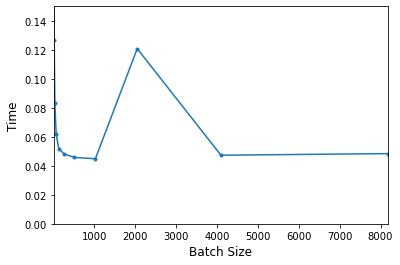

In [38]:
plt.plot(epoch_list, time_list, marker='.')
plt.xlim(1, epoch_list[-1])
plt.ylim(0.0, 0.15)
plt.xlabel('Batch Size', fontsize='12')
plt.ylabel('Time', fontsize='12')
plt.show()

***
**グラフの考察**
- 前提　
  - BatchSize=xでの重み更新の回数
    - 重み更新回数＝データ量/x
  - 重み更新が少ないほど学習時間が減る→BatchSizeが大きいほど学習時間が減る？
- 仮説
  - BatchSizeが500と1000で学習時間があまり変わらないのはなぜか
    - 重み更新回数が22回（10672/500）と11回（10672/1000）では大した学習時間の差が出ない
  - BatchSizeが1と2で学習時間に大きな差が出るのはなぜか
    - 重み更新が回数が10672回（10672/1）と5336回（10672/2）では学習時間に大きな差が出る
  - なぜBatchSizeが2000~3000あたりにおいて学習時間が極大値をとっているのか
    - BatchSize=1000とBatchSize=2000を比較
      - 重み更新回数での比較
        - BatchSize=1000では11回、BatchSize=2000では6回
        - 重みの更新回数の差による時間削減＜１度に重み×特徴量を行うデータ数による時間増加
***

## 78. GPU上での学習

問題77のコードを改変し，GPU上で学習を実行せよ．

In [39]:
#deviceの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [40]:
#特徴量とラベルをgpuに送る
X_train_gpu = X_train.to(device)
Y_train_gpu = Y_train.to(device)

dataset = DataSet(X_train_gpu, Y_train_gpu)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=3, shuffle=False)

In [41]:
time_list, epoch_list = [], []
i = 0
while(pow(2, i) <= len(X_train_gpu)):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=pow(2, i), shuffle=False)
    start_time = time.perf_counter()
    for data in dataloader:
        optimizer.zero_grad()  # 重みとバイアスの更新で内部的に使用するデータをリセット
        outputs = model(data[0])  # 手順1：ニューラルネットワークにデータを入力
        loss = loss_entropy(outputs, data[1])  # 手順2：正解ラベルとの比較
        loss.backward()  # 手順3-1：誤差逆伝播
        optimizer.step()  # 手順3-2：重みとバイアスの更新
    end_time = time.perf_counter()    
    epoch_list.append(pow(2, i))
    time_list.append(end_time - start_time)
    i += 1

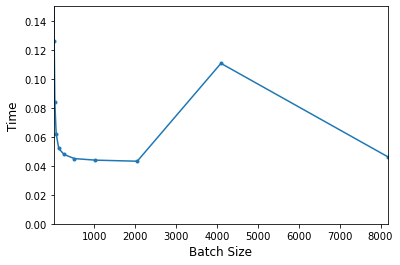

In [42]:
plt.plot(epoch_list, time_list, marker='.')
plt.xlim(1, epoch_list[-1])
plt.ylim(0.0, 0.15)
plt.xlabel('Batch Size', fontsize='12')
plt.ylabel('Time', fontsize='12')
plt.show()

## 79. 多層ニューラルネットワーク

問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ

In [43]:
activation = nn.Softmax(dim=0)
relu = nn.ReLU()

In [44]:
#ニューラルネットワーク構築
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(300, 100)
        self.layer2 = nn.Linear(100, 50)
        self.layer3 = nn.Linear(50, 4)
        
    def forward(self, x):
        x = relu(self.layer1(x))
        x = relu(self.layer2(x))
        x = self.layer3(x)
        return x
    
model = NeuralNetwork()

In [46]:
#損失関数の定義
loss_entropy = nn.CrossEntropyLoss()
#最適化手法の決定
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [ ]:
EPOCHS = 2000  # 上と同じことを2000回繰り返す
for epoch in range(EPOCHS):
    optimizer.zero_grad()  # 重みとバイアスの更新で内部的に使用するデータをリセット
    outputs = model(X_train)  # 手順1：ニューラルネットワークにデータを入力
    loss = loss_entropy(outputs, Y_train)  # 手順2：正解ラベルとの比較
    loss.backward()  # 手順3-1：誤差逆伝播
    optimizer.step()  # 手順3-2：重みとバイアスの更新

#活性化関数の定義
activation = nn.Softmax(dim=0)

In [49]:
#訓練データでの正解率計算
accuracy(X_train, Y_train)

0.9020802098950524

In [51]:
dataset = DataSet(X_train, Y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=3, shuffle=False)

In [52]:
time_list, epoch_list = [], []
i = 0
while(pow(2, i) <= len(X_train)):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=pow(2, i), shuffle=False)
    start_time = time.perf_counter()
    for data in dataloader:
        optimizer.zero_grad()  # 重みとバイアスの更新で内部的に使用するデータをリセット
        outputs = model(data[0])  # 手順1：ニューラルネットワークにデータを入力
        loss = loss_entropy(outputs, data[1])  # 手順2：正解ラベルとの比較
        loss.backward()  # 手順3-1：誤差逆伝播
        optimizer.step()  # 手順3-2：重みとバイアスの更新
    end_time = time.perf_counter()    
    epoch_list.append(pow(2, i))
    time_list.append(end_time - start_time)
    i += 1

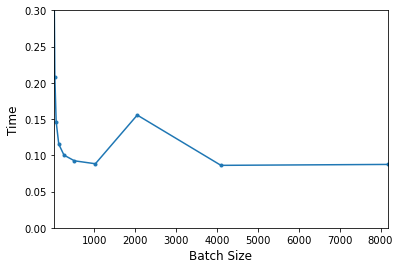

In [54]:
plt.plot(epoch_list, time_list, marker='.')
plt.xlim(1, epoch_list[-1])
plt.ylim(0.0, 0.30)
plt.xlabel('Batch Size', fontsize='12')
plt.ylabel('Time', fontsize='12')
plt.show()

In [63]:
EPOCHS = 200

In [64]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=False)
for epoch in range(EPOCHS):
    for data in dataloader:
        optimizer.zero_grad()  # 重みとバイアスの更新で内部的に使用するデータをリセット
        outputs = model(data[0])  # 手順1：ニューラルネットワークにデータを入力
        loss = loss_entropy(outputs, data[1])  # 手順2：正解ラベルとの比較
        loss.backward()  # 手順3-1：誤差逆伝播
        optimizer.step()  # 手順3-2：重みとバイアスの更新

In [65]:
#訓練データでの正解率計算
accuracy(X_train, Y_train)

0.966079460269865

In [66]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=500, shuffle=False)
for epoch in range(EPOCHS):
    for data in dataloader:
        optimizer.zero_grad()  # 重みとバイアスの更新で内部的に使用するデータをリセット
        outputs = model(data[0])  # 手順1：ニューラルネットワークにデータを入力
        loss = loss_entropy(outputs, data[1])  # 手順2：正解ラベルとの比較
        loss.backward()  # 手順3-1：誤差逆伝播
        optimizer.step()  # 手順3-2：重みとバイアスの更新

In [67]:
#訓練データでの正解率計算
accuracy(X_train, Y_train)

0.9812593703148426

本来であれば
　訓練データで、エポック数やバッチサイズ、層の数、活性化関数、学習率などを変える→検証データの結果からパラメータを調整→テストデータで最終テスト